In [1]:
import os
import random
import sys

try:
    sys.path.remove('/Users/vblot/Documents/projects/mapie/original/MAPIE')
    sys.path.remove('/Users/vblot/Documents/projects/mapie/original/MAPIE')
except:
    pass
sys.path.append("/Users/vblot/Documents/projects/cemracs/conformalized_gp/")
# sys.path.append("/Users/vblot/Documents/projects/cemracs/conformal_uq")

import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
import openturns as ot
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.stats import bootstrap, pearsonr, permutation_test
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from mapie.conformity_scores.residual_conformity_scores import GPCrossConformityScore
from mapie.metrics import regression_coverage_score_v2, regression_mean_width_score
from mapie.regression import MapieRegressor
import mmd
from notebooks_gp.adaptivity_measures import hsic_ot, bootstrap_correlation, my_correlation, recap_permutation_test, spline_mse, tree_mse
from notebooks_gp.plot_functions import plot_distribution, plot_prediction_intervals, plot_width_error
from wrappers import GpOTtoSklearnExpStd, GpOTtoSklearnStd


plt.rcParams["figure.dpi"] = 100
%load_ext autoreload
%autoreload 2


# Get data

In [2]:
DATA_PATH = "/Users/vblot/Documents/projects/cemracs/data_UQ"
EDF_BLUE = np.array([[26, 54, 105]]) / 255
CAP_BLUE = np.array([[48, 112, 170]]) / 255
PS_VIOLET = np.array([[84, 13, 46]]) / 255
EDF_ORANGE = np.array([[223, 84, 49]]) / 255
LISN_YELLOW = np.array([[242, 188, 64]]) / 255
METHOD = "plus"
N_POINTS_TRAIN = "all"
CV = 10
SAVE_PLOT = False


In [3]:
X = np.load(os.path.join(DATA_PATH, "x.npy"))
y = np.load(os.path.join(DATA_PATH, "g_x.npy"))

In [4]:
print(X.shape, y.shape)

(8, 1000) (1000,)


# Split into train test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=.2, random_state=42)
n_train = N_POINTS_TRAIN
n_train = len(X_train) if type(n_train) == str else n_train
random.seed(42)
indexes_train = np.random.choice(range(len(X_train)), n_train, replace=False)
X_train = X_train[indexes_train]
y_train = y_train[indexes_train]

In [6]:
print(
    f"  N training points = {len(X_train)}\n",
    f" N testing points = {len(X_test)}"
)

  N training points = 800
  N testing points = 200


# Get data

In [7]:
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Fit GP

In [8]:
#Input laws
x_1 = ot.Normal(101.6612, 4.0)
x_2 = ot.Normal(0.0233, 0.0005)
x_3 = ot.Triangular(0.5e-6, 5.0e-6, 10.0e-6)
x_4 = ot.Triangular(0.2, 0.3, 0.5)
x_5 = ot.Triangular(0.0, 0.05, 0.3)
x_6 = ot.Triangular(1.3e-09, 4.4e-09, 7.8e-09)
x_7 = ot.Triangular(5.0e-9, 7.5e-9, 10.0e-9)
x_8 = ot.Triangular(0.0001, 0.0015, 0.003)

marginals = [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8]
distribution = ot.ComposedDistribution(marginals)

nu = 5/2

In [9]:
models = {
    "CV+GP": {
        "estimator": GpOTtoSklearnStd(scale=1, amplitude=1.0, nu=nu),
        "color": LISN_YELLOW
    },
    "CV-minmax-GP": {
        "estimator": GpOTtoSklearnStd(scale=1, amplitude=1.0, nu=nu),
        "color": EDF_ORANGE
    },
    "CV+": {
        "estimator": GpOTtoSklearnStd(scale=1, amplitude=1.0, nu=nu),
        "color": "green"
    },
    "CV-minmax": {
        "estimator": GpOTtoSklearnStd(scale=1, amplitude=1.0, nu=nu),
        "color": PS_VIOLET
    },
     "GP": {
        "estimator": GpOTtoSklearnStd(scale=1, amplitude=1.0, nu=nu),
        "color": "black"
    }
}

In [10]:
for model_name, model in models.items():
    print("Fitting ", model_name)
    model["estimator"].fit(X_train_scale, y_train)


Fitting  CV+GP
Fitting  CV-minmax-GP


WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]


Fitting  CV+
Fitting  CV-minmax
Fitting  GP


In [11]:
for model_name, model in models.items():
    print(model_name, mean_squared_error(y_test, model["estimator"].predict(X_test_scale)))

CV+GP 0.33128450526324715
CV-minmax-GP 0.33128450526324715
CV+ 0.33128450526324715
CV-minmax 0.33128450526324715
GP 0.33128450526324715


# Fit MAPIE

In [12]:
for model_name, model in models.items():
    if "+" in model_name:
        METHOD = "plus"
    else:
        METHOD = "minmax"
    models[model_name]["mapie_estimator"] = MapieRegressor(
        estimator=model["estimator"],
        conformity_score=GPCrossConformityScore(sym=True) if "GP" in model_name else None,
        cv=CV,
        method=METHOD,
        model_has_std=True if "GP" in model_name else False,
        random_state=42
    )


In [13]:
for model_name, model in models.items():
    print("Fitting MAPIE", model_name)
    model["mapie_estimator"].fit(X_train_scale, y_train)


Fitting MAPIE CV+GP


WRN - (previous message repeated 5 times)
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.78219,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.467,12.326,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3293,9.7907,9.10726,8.38285,8.87768,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.9492,12.3298,9.7907,9.13852,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.51241,9.18946,8.38285,9.03792,9.17566,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.37411,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792

Fitting MAPIE CV-minmax-GP



WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.78219,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.467,12.326,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3293,9.7907,9.10726,8.38285,8.87768,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.9492,12.3298,9.7907,9.13852,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.51241,9.18946,8.38285,9.03792,9.17566,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.37411,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For cohe

Fitting MAPIE CV+


WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.78219,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.467,12.326,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3293,9.7907,9.10726,8.38285,8.87768,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.9492,12.3298,9.7907,9.13852,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.51241,9.18946,8.38285,9.03792,9.17566,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.37411,9.03792,9.32553,9.58801]
WRN - Warning! For coher

Fitting MAPIE CV-minmax


WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.78219,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.467,12.326,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3293,9.7907,9.10726,8.38285,8.87768,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.9492,12.3298,9.7907,9.13852,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.51241,9.18946,8.38285,9.03792,9.17566,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.37411,9.03792,9.32553,9.58801]
WRN - Warning! For coher

Fitting MAPIE GP


WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.78219,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.467,12.326,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3293,9.7907,9.10726,8.38285,8.87768,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [11.9492,12.3298,9.7907,9.13852,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.51241,9.18946,8.38285,9.03792,9.17566,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.38285,9.03792,9.32553,9.58801]
WRN - Warning! For coherency we set scale upper bounds = [12.0024,12.3298,9.7907,9.18946,8.37411,9.03792,9.32553,9.58801]
WRN - Warning! For coher

# Coverage

In [14]:
ALPHA = np.arange(0.01, .99, 0.01)
q_alpha_min = scipy.stats.norm.ppf(ALPHA / 2)
q_alpha_max = scipy.stats.norm.ppf(1 - ALPHA / 2)
y_mean, y_std = models["GP"]["estimator"].predict(X_test_scale, return_std=True)
y_pss_gp = np.concatenate(
    [
        (y_mean.reshape(-1, 1) + y_std.reshape(-1, 1) * q_alpha_min.reshape(1, -1))[:, np.newaxis, :],
        (y_mean.reshape(-1, 1) + y_std.reshape(-1, 1) * q_alpha_max.reshape(1, -1))[:, np.newaxis, :]
    ],
    axis=1
)
models["GP"]["y_pss"] = y_pss_gp

In [15]:
models.keys()

dict_keys(['CV+GP', 'CV-minmax-GP', 'CV+', 'CV-minmax', 'GP'])

In [16]:
for model_name, model in models.items():
    if model_name != "GP":
        print("Predict MAPIE", model_name)
        _, y_pss = model["mapie_estimator"].predict(X_test_scale, alpha=ALPHA)
        model["y_pss"] = y_pss


Predict MAPIE CV+GP
Predict MAPIE CV-minmax-GP
Predict MAPIE CV+
Predict MAPIE CV-minmax


In [17]:
for model_name, model in models.items():
    model["coverage"] = [
        regression_coverage_score_v2(y_test, model["y_pss"][:, :, i])
        for i, _ in enumerate(ALPHA)
    ]
    model["average_width"] = [
        regression_mean_width_score(
            model["y_pss"][:, 1, i], model["y_pss"][:, 0, i]
        )
        for i, _ in enumerate(ALPHA)
    ]
    model["median_width"] = [
        np.median(np.abs(
             model["y_pss"][:, 1, i] -  model["y_pss"][:, 0, i]
        ))
        for i, _ in enumerate(ALPHA)
    ]
    model["var_width"] = [
        np.std(np.abs(
             model["y_pss"][:, 1, i] -  model["y_pss"][:, 0, i]
        ))
        for i, _ in enumerate(ALPHA)
    ]


CV+GP
CV-minmax-GP
CV+
CV-minmax
GP


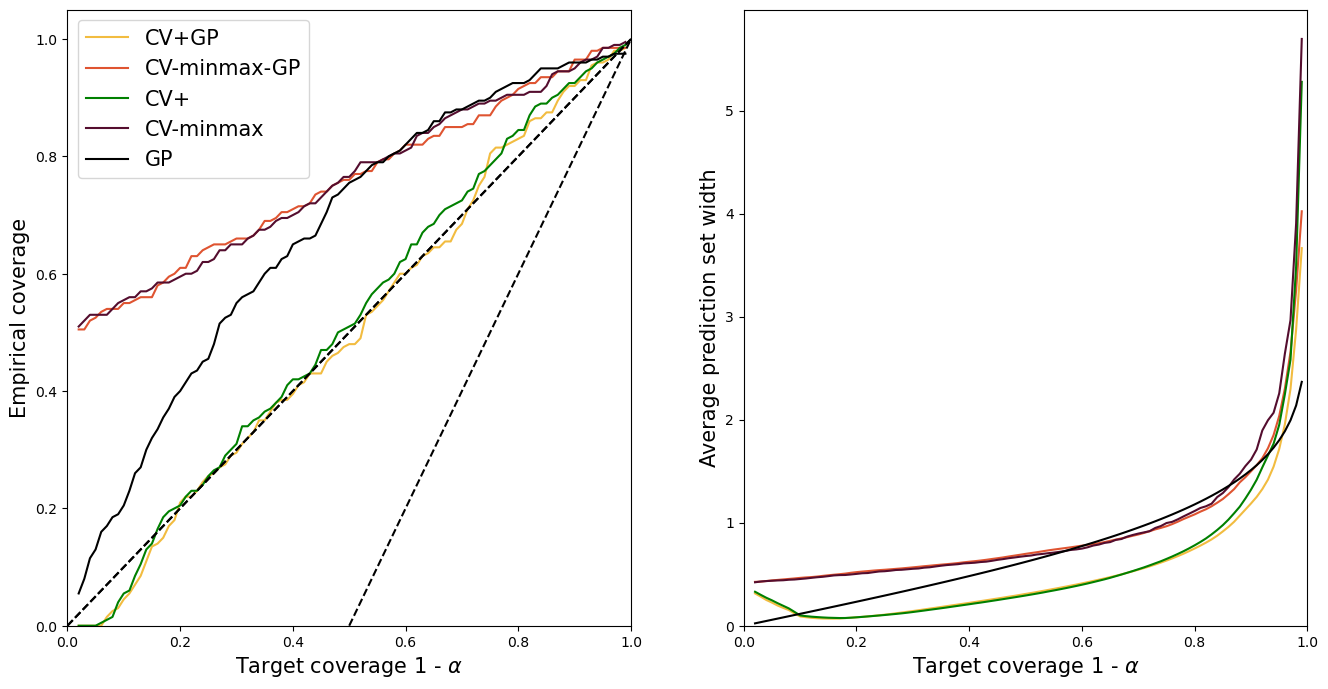

In [18]:
fs = 15
ncols = 2
nrows = 1
s = 8
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for model_name, model in models.items():
    print(model_name)
    cov = model["coverage"]
    ax[0, 0].plot(1 - ALPHA, cov, label=model_name, c=model["color"])
ax[0, 0].plot([[0, 0], [1, 1]], linestyle='dashed', c='black')
ax[0, 0].plot([0.5, 1], [0, 1], linestyle='dashed', c='black')
ax[0, 0].set_ylabel("Empirical coverage", fontsize=fs)


for model_name, model in models.items():
    width = model["average_width"]
    ax[0, 1].plot(1 - ALPHA, width, label=model_name, c=model["color"])
ax[0, 1].set_ylabel("Average prediction set width", fontsize=fs)

for i in (0, 1):
        ax[0, i].set_xlabel(r"Target coverage 1 - $\alpha$", fontsize=fs)
        ax[0, i].set_xlim(0, 1)
        ax[0, i].set_ylim(0)

ax[0, 0].legend(fontsize=15, loc="upper left")


# Size Stratified Coverage


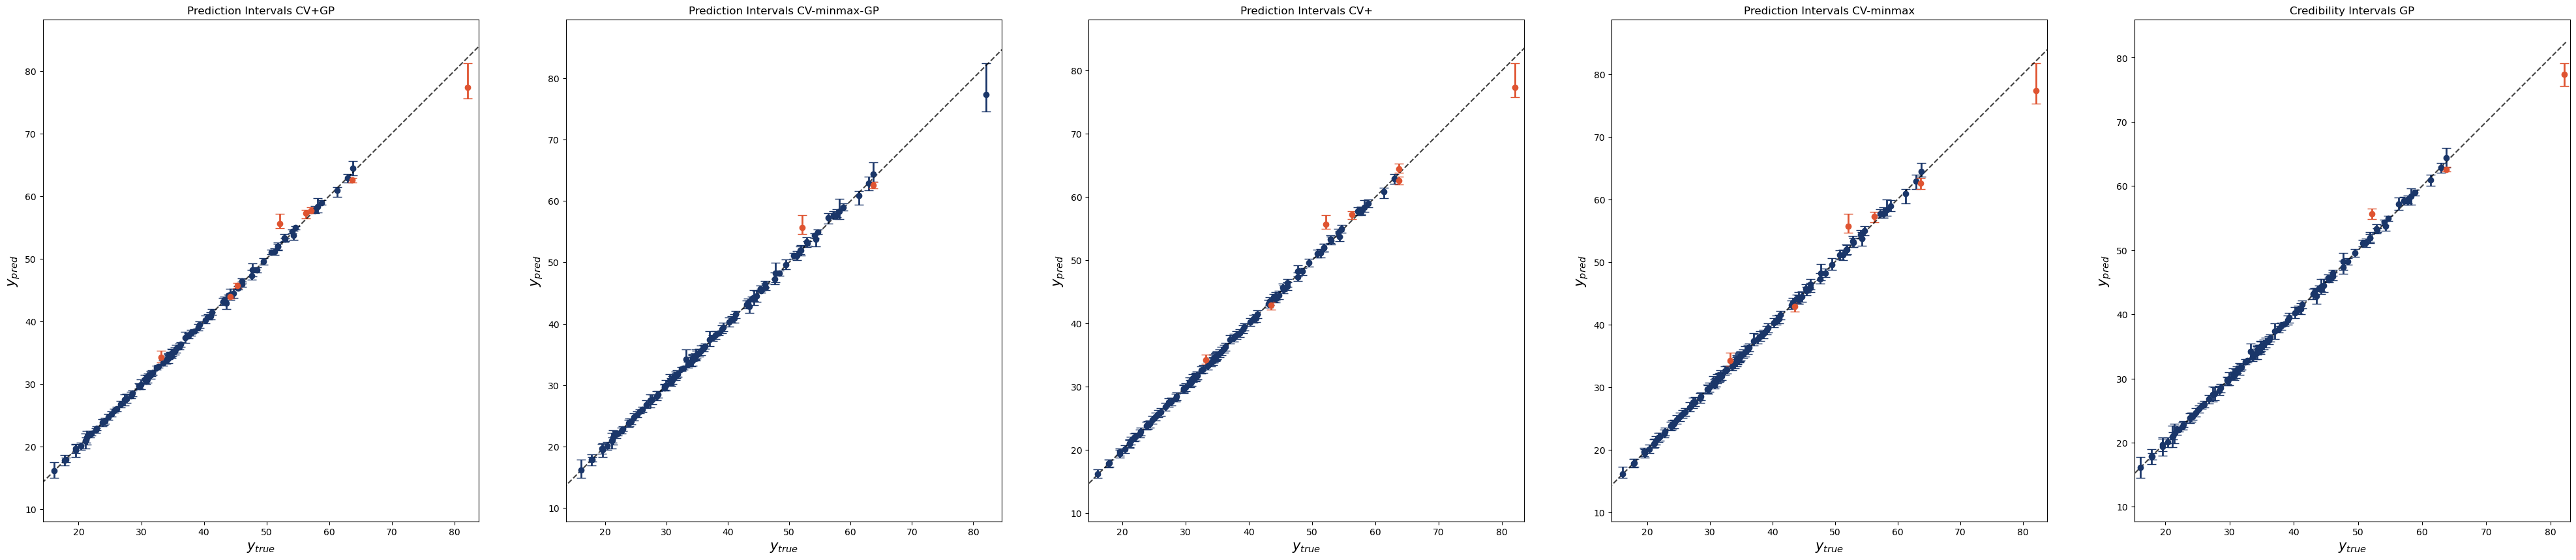

In [19]:
s = 10
nrows = 1
ncols = len(models)
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for i, model_name in enumerate(models.keys()):
    if model_name == "GP":
        interval_name = "Credibility Intervals "
    else:
        interval_name = "Prediction Intervals "
    plot_prediction_intervals(
        interval_name + model_name,
        ax[0, i],
        y_test, 
        y_mean,
        models[model_name]["y_pss"][:, :, 9],
        n_points_plot=100
    )


# Correlation between width of the Prediction Interval and the error of the model


In [20]:
for model_name, model in models.items():
    model["errors"] = np.abs(model["estimator"].predict(X_test_scale) - y_test)
    model["width"] = np.abs(model["y_pss"][:, 0, 9] - model["y_pss"][:, 1, 9])

In [21]:
for model_name, model in models.items():
    str_vect = [e + '--' + w for e, w in zip(model["errors"].astype("str").tolist(), model["width"].astype("str").tolist())]
    model["correlation_to_error"] = bootstrap(
        (np.array(str_vect), ),
        my_correlation,
        axis=0
    )
    model["hsic_to_error"] = hsic_ot(
        model["errors"],
        model["width"]
    )


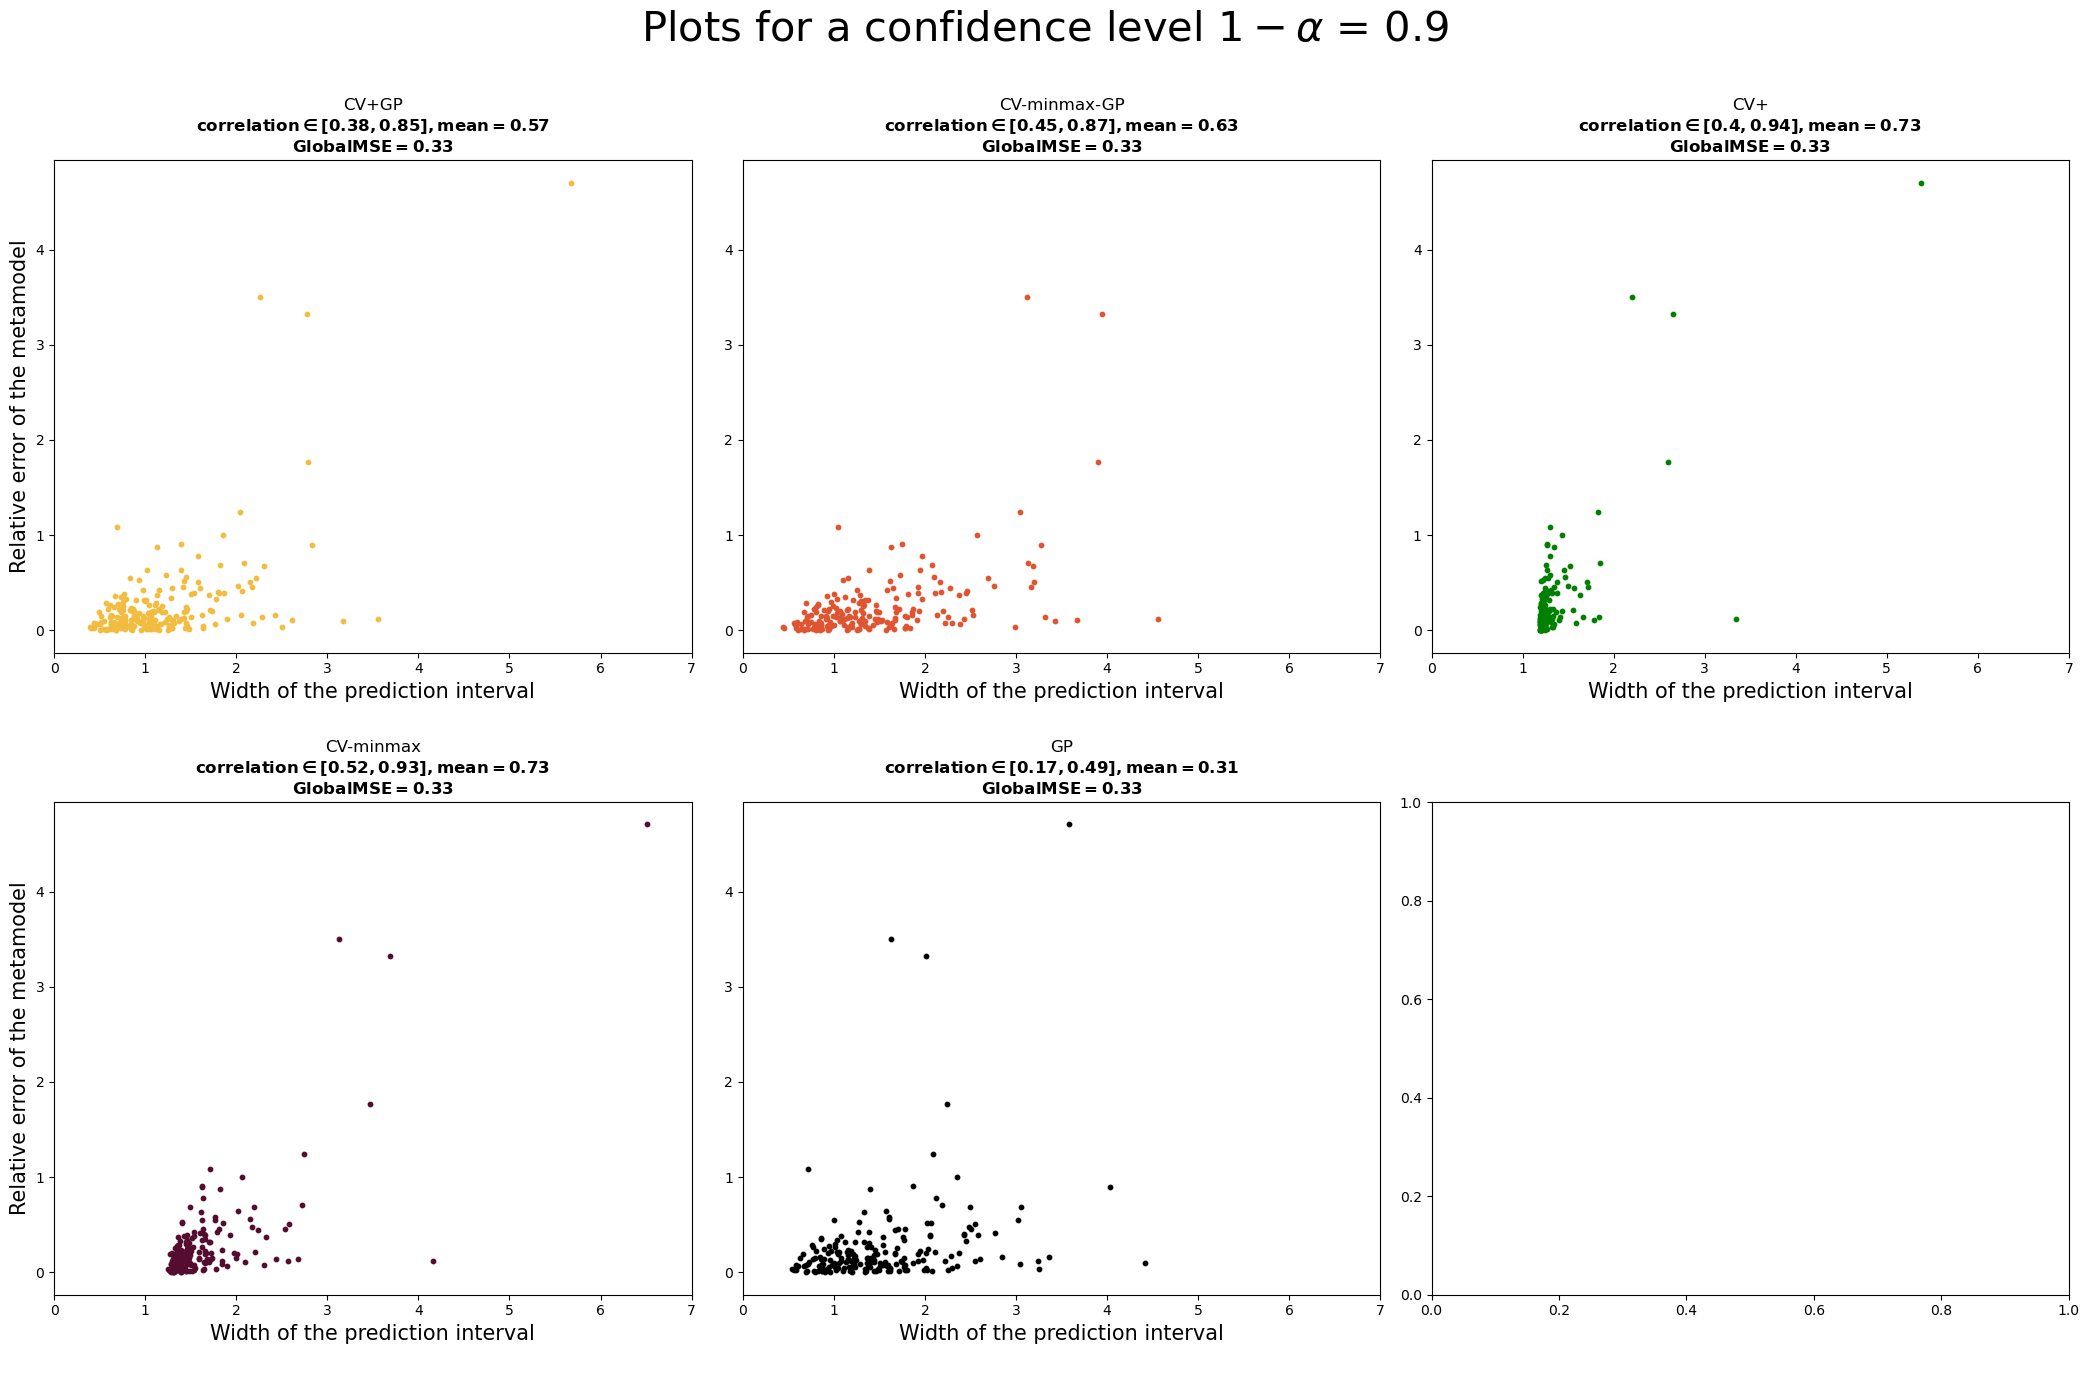

In [22]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)
ci_name = "correlation"

for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    ci = model["correlation_to_error"].confidence_interval
    mean_correlation = np.mean(model["correlation_to_error"].bootstrap_distribution)
    plot_width_error(model, model_name, ci, mean_correlation, ci_name, ax, r, c)
f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[9], 2)) + "\n", fontsize=30)

plt.tight_layout()

## Plot correlations and p-values distributions

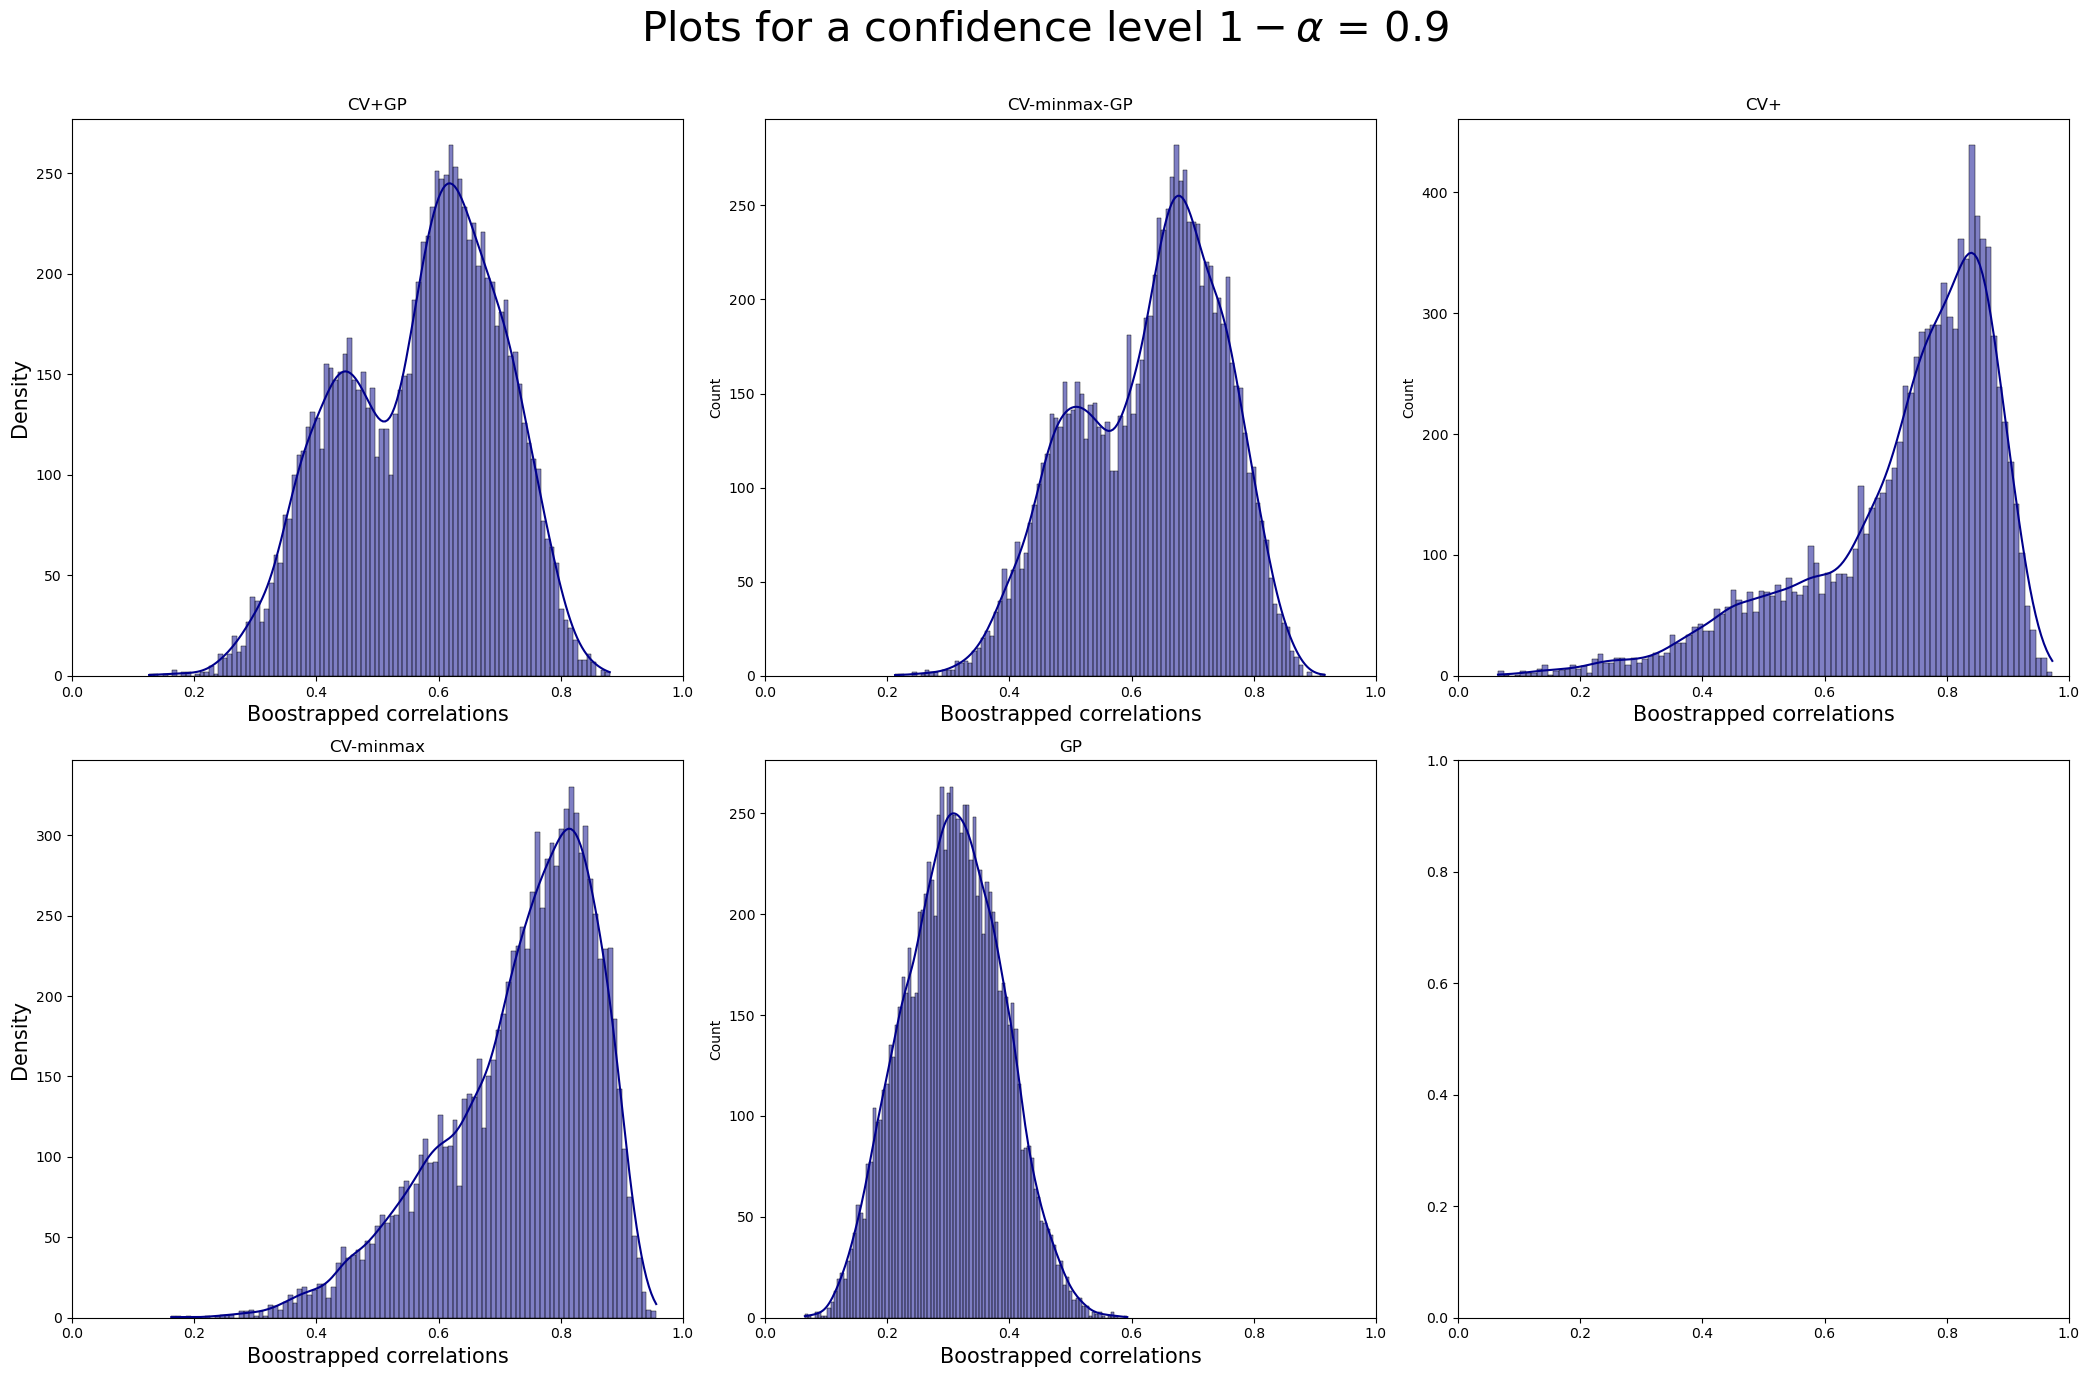

In [23]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    distribution = model["correlation_to_error"].bootstrap_distribution
    plot_distribution(
        distribution, model_name, "Boostrapped correlations", ax[r, c]
    )
    ax[r, 0].set_ylabel("Density", size=15)

f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[9], 2)) + "\n", fontsize=30)

plt.tight_layout()

## Permutation test to test that the correlation with CP is higher than without

In [24]:
recap_permutation_test(models, "correlation_to_error", alternative="less")


,test statistic,p-value
gp_vs_gp_plus,-0.261814,0.0001
gp_vs_cv_plus,-0.420250,0.0001
cv_plus_vs_gp_plus,0.158436,1.0000
gp_vs_gp_minmax,-0.320777,0.0001
gp_plus_vs_gp_minmax,-0.058963,0.0001


In [25]:
for model_name, model in models.items():
    y_above_inf = y_test >= model["y_pss"][:, 0, 9]
    y_bellow_sup = y_test <= model["y_pss"][:, 1, 9]

    model["y_true_in_interval"] = y_above_inf * y_bellow_sup
    

In [26]:
dict_hsic = {}

for model_name, model in models.items():
    hsic_result = hsic_ot(
        model["y_true_in_interval"],
        np.abs(
            model["y_pss"][:, 0, 9] - model["y_pss"][:, 1, 9]
        )
    )
    dict_hsic[model_name] = {
        "HSIC-stat": hsic_result[0],
        "p-value": hsic_result[1]
    }

In [27]:
pd.DataFrame(dict_hsic).T

,HSIC-stat,p-value
CV+GP,0.018952,0.104893
CV-minmax-GP,0.049590,0.036188
CV+,0.149701,0.008448
CV-minmax,0.112543,0.011386
GP,0.008235,0.352539


# Fit model to predict error with size of PS

In [28]:
for model_name, model in models.items():
    
    width = np.abs(model["y_pss"][:, 0, 9] - model["y_pss"][:, 1, 9])
    str_vect = [e + '--' + w for e, w in zip( width.astype("str").tolist(), model["errors"].astype("str").tolist())]
    # model["spline_mse"] = bootstrap(
    #     (np.array(str_vect), ),
    #     spline_mse,
    #     axis=0
    # )
    model["tree_mse"] = bootstrap(
        (np.array(str_vect), ),
        tree_mse,
        axis=0
    )

In [29]:
# ncols = 3
# nrows = len(models) // ncols + (len(models) % ncols != 0)
# s = 7
# f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)
# ci_name = "Spline MSE"


# for i, (model_name, model) in enumerate(models.items()):
#     r, c = i // ncols, i % ncols
#     ci = model["spline_mse"].confidence_interval
#     mean_mse = model["spline_mse"].bootstrap_distribution.mean()
#     plot_width_error(model, model_name, ci, mean_mse, ci_name, ax, r, c)
# f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[9], 2)) + "\n", fontsize=30)

# plt.tight_layout()



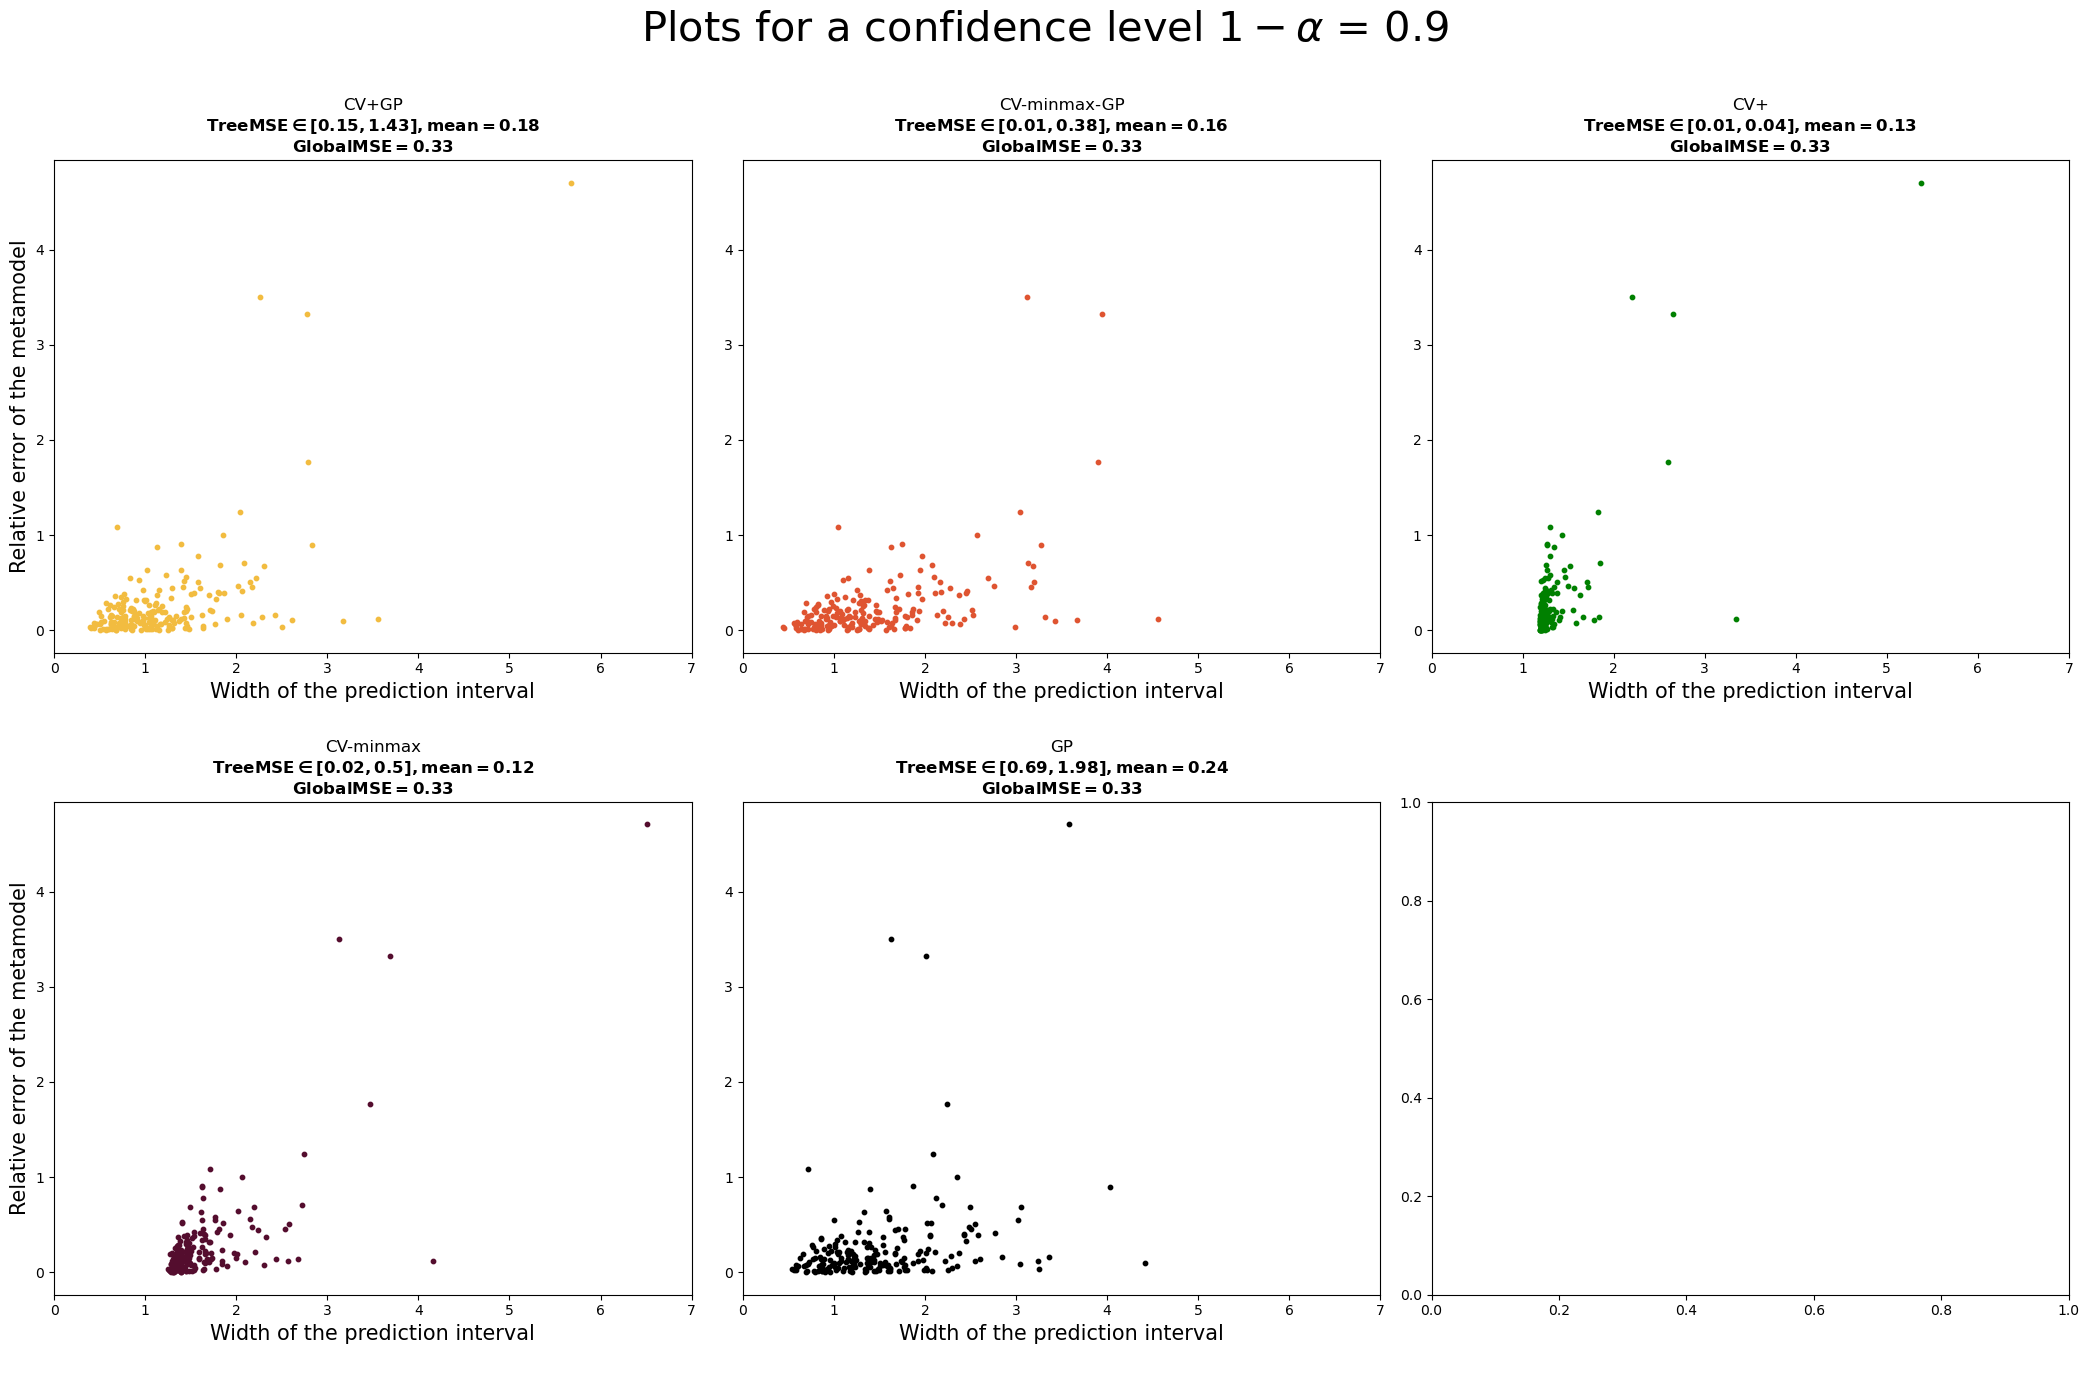

In [30]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)
ci_name = "Tree MSE"


for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    ci = model["tree_mse"].confidence_interval
    mean_mse = model["tree_mse"].bootstrap_distribution.mean()
    plot_width_error(model, model_name, ci, mean_mse, ci_name, ax, r, c)
f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[9], 2)) + "\n", fontsize=30)

plt.tight_layout()



In [31]:
# ncols = 3
# nrows = len(models) // ncols + (len(models) % ncols != 0)
# s = 7
# f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

# for i, (model_name, model) in enumerate(models.items()):
#     r, c = i // ncols, i % ncols
#     distribution = model["spline_mse"].bootstrap_distribution
#     plot_distribution(
#         distribution, model_name, "Boostrapped Spline MSE", ax[r, c]
#     )
#     ax[r, 0].set_ylabel("Density", size=15)
# f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[9], 2)) + "\n", fontsize=30)

# plt.tight_layout()


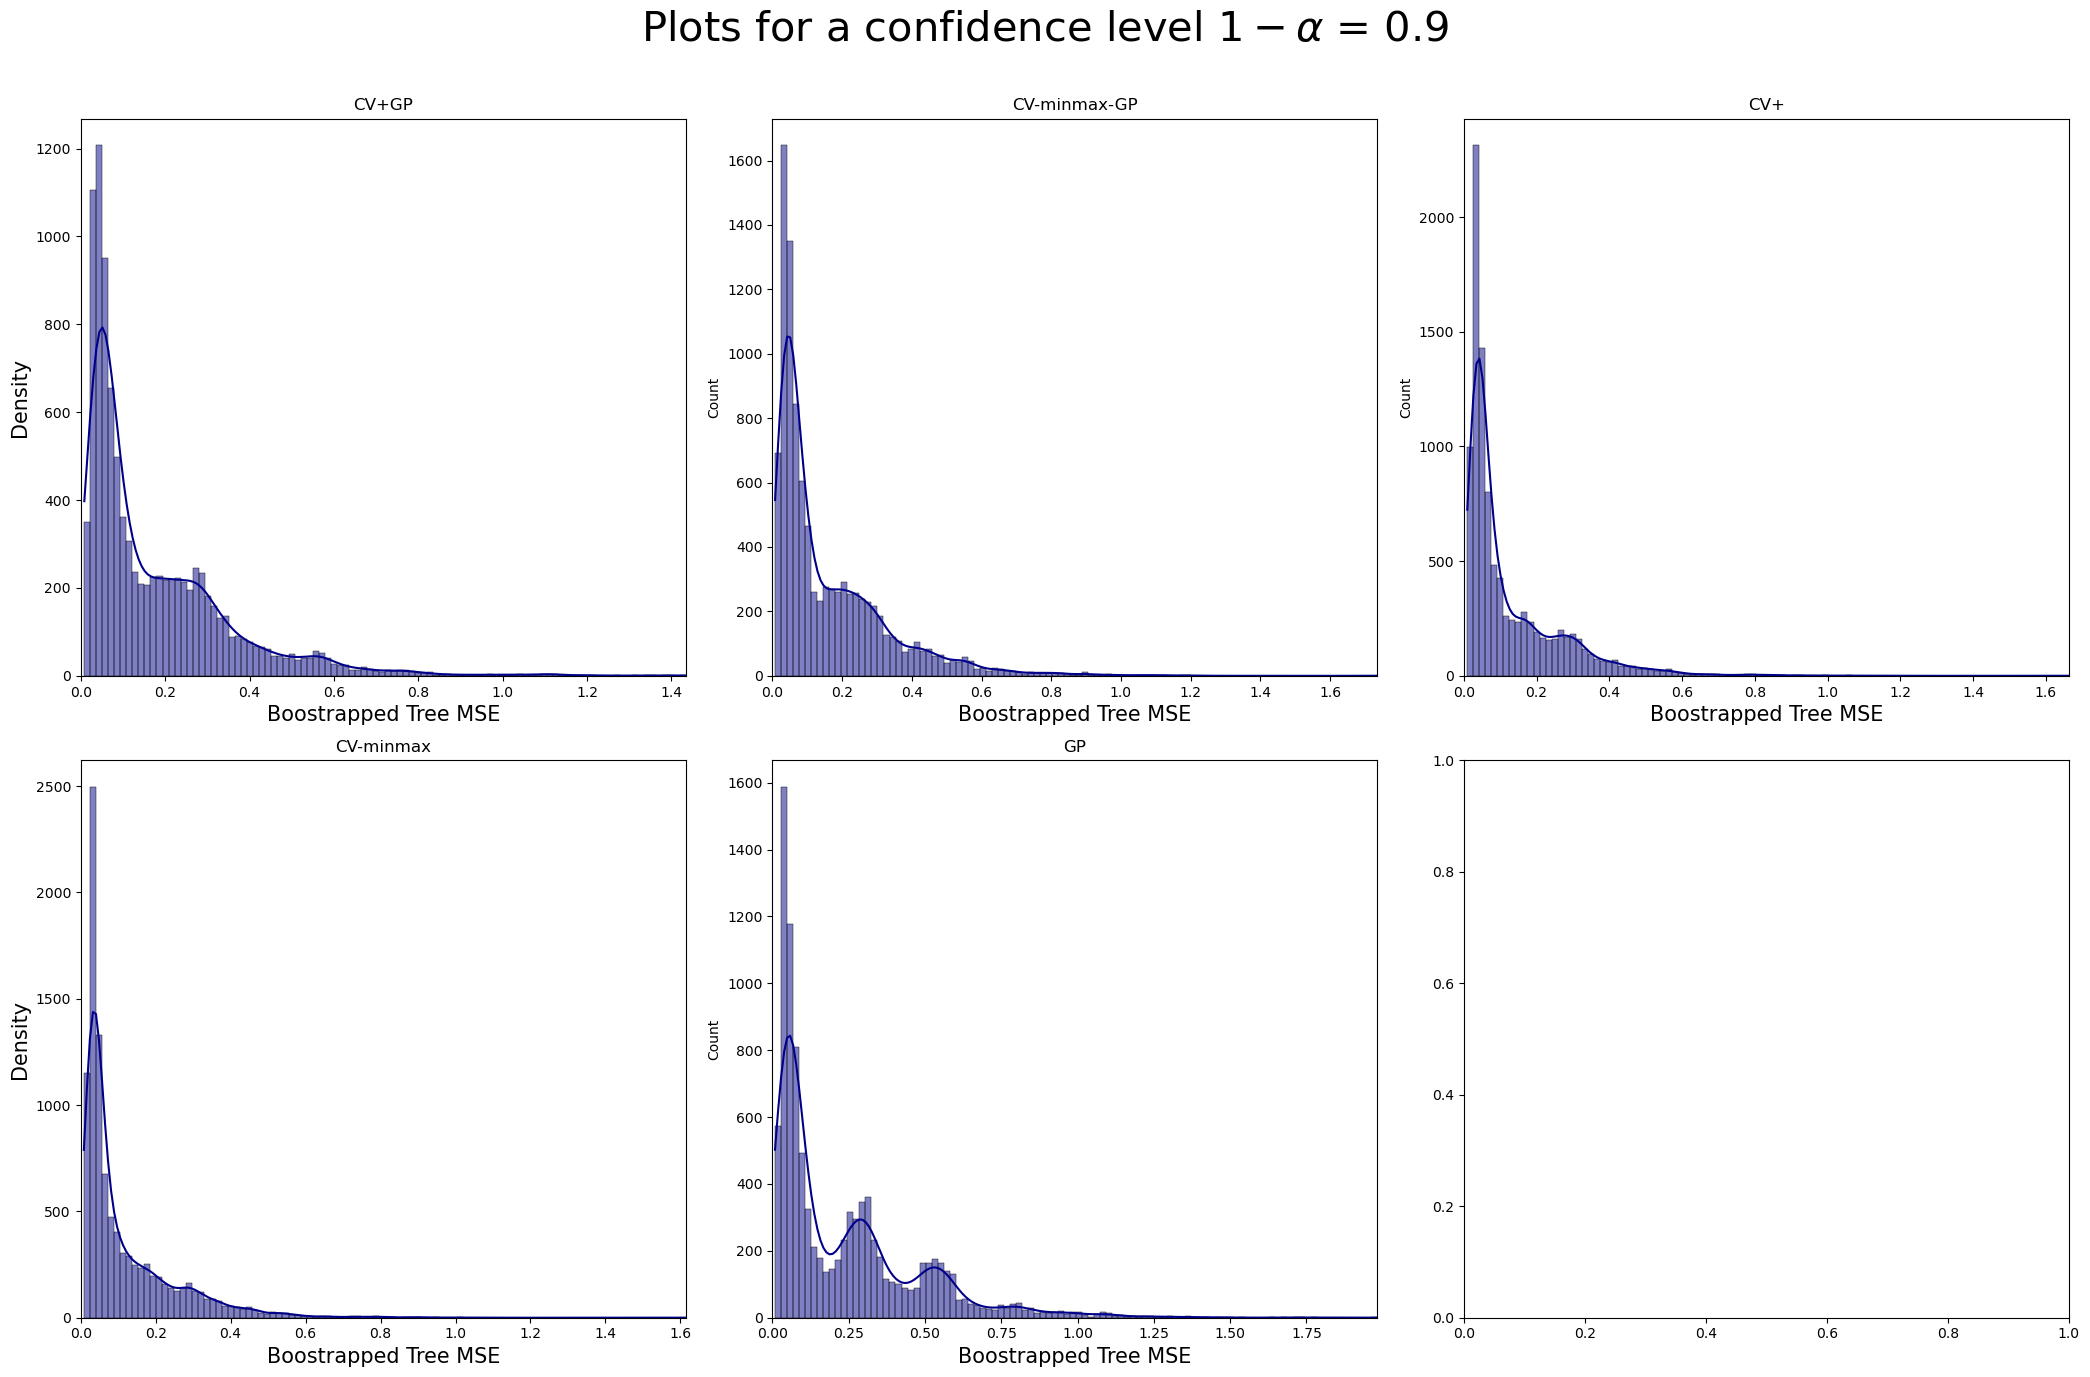

In [32]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)

for i, (model_name, model) in enumerate(models.items()):
    r, c = i // ncols, i % ncols
    distribution = model["tree_mse"].bootstrap_distribution
    plot_distribution(
        distribution, model_name, "Boostrapped Tree MSE", ax[r, c]
    )
    ax[r, 0].set_ylabel("Density", size=15)
f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[9], 2)) + "\n", fontsize=30)

plt.tight_layout()


In [33]:
# recap_permutation_test(models, "spline_mse", alternative="greater")

In [34]:
recap_permutation_test(models, "tree_mse", alternative="greater")

,test statistic,p-value
gp_vs_gp_plus,0.060001,0.0001
gp_vs_cv_plus,0.108118,0.0001
cv_plus_vs_gp_plus,-0.048116,1.0000
gp_vs_gp_minmax,0.073525,0.0001
gp_plus_vs_gp_minmax,0.013524,0.0001


Ajouter comparaison avec la moyenne

size stratified coverage

impact de epsilon

taille des intervalles comme critères de sélection du modèle

il se passe quoi si on bouge le noyau et autres HP du modèle

Mondrian ? Quelles intuitions métier ?

Ils veulent en faire quoi de l'inférence ?

Code papier Bertrand



## Visualize DecisionTree frontier

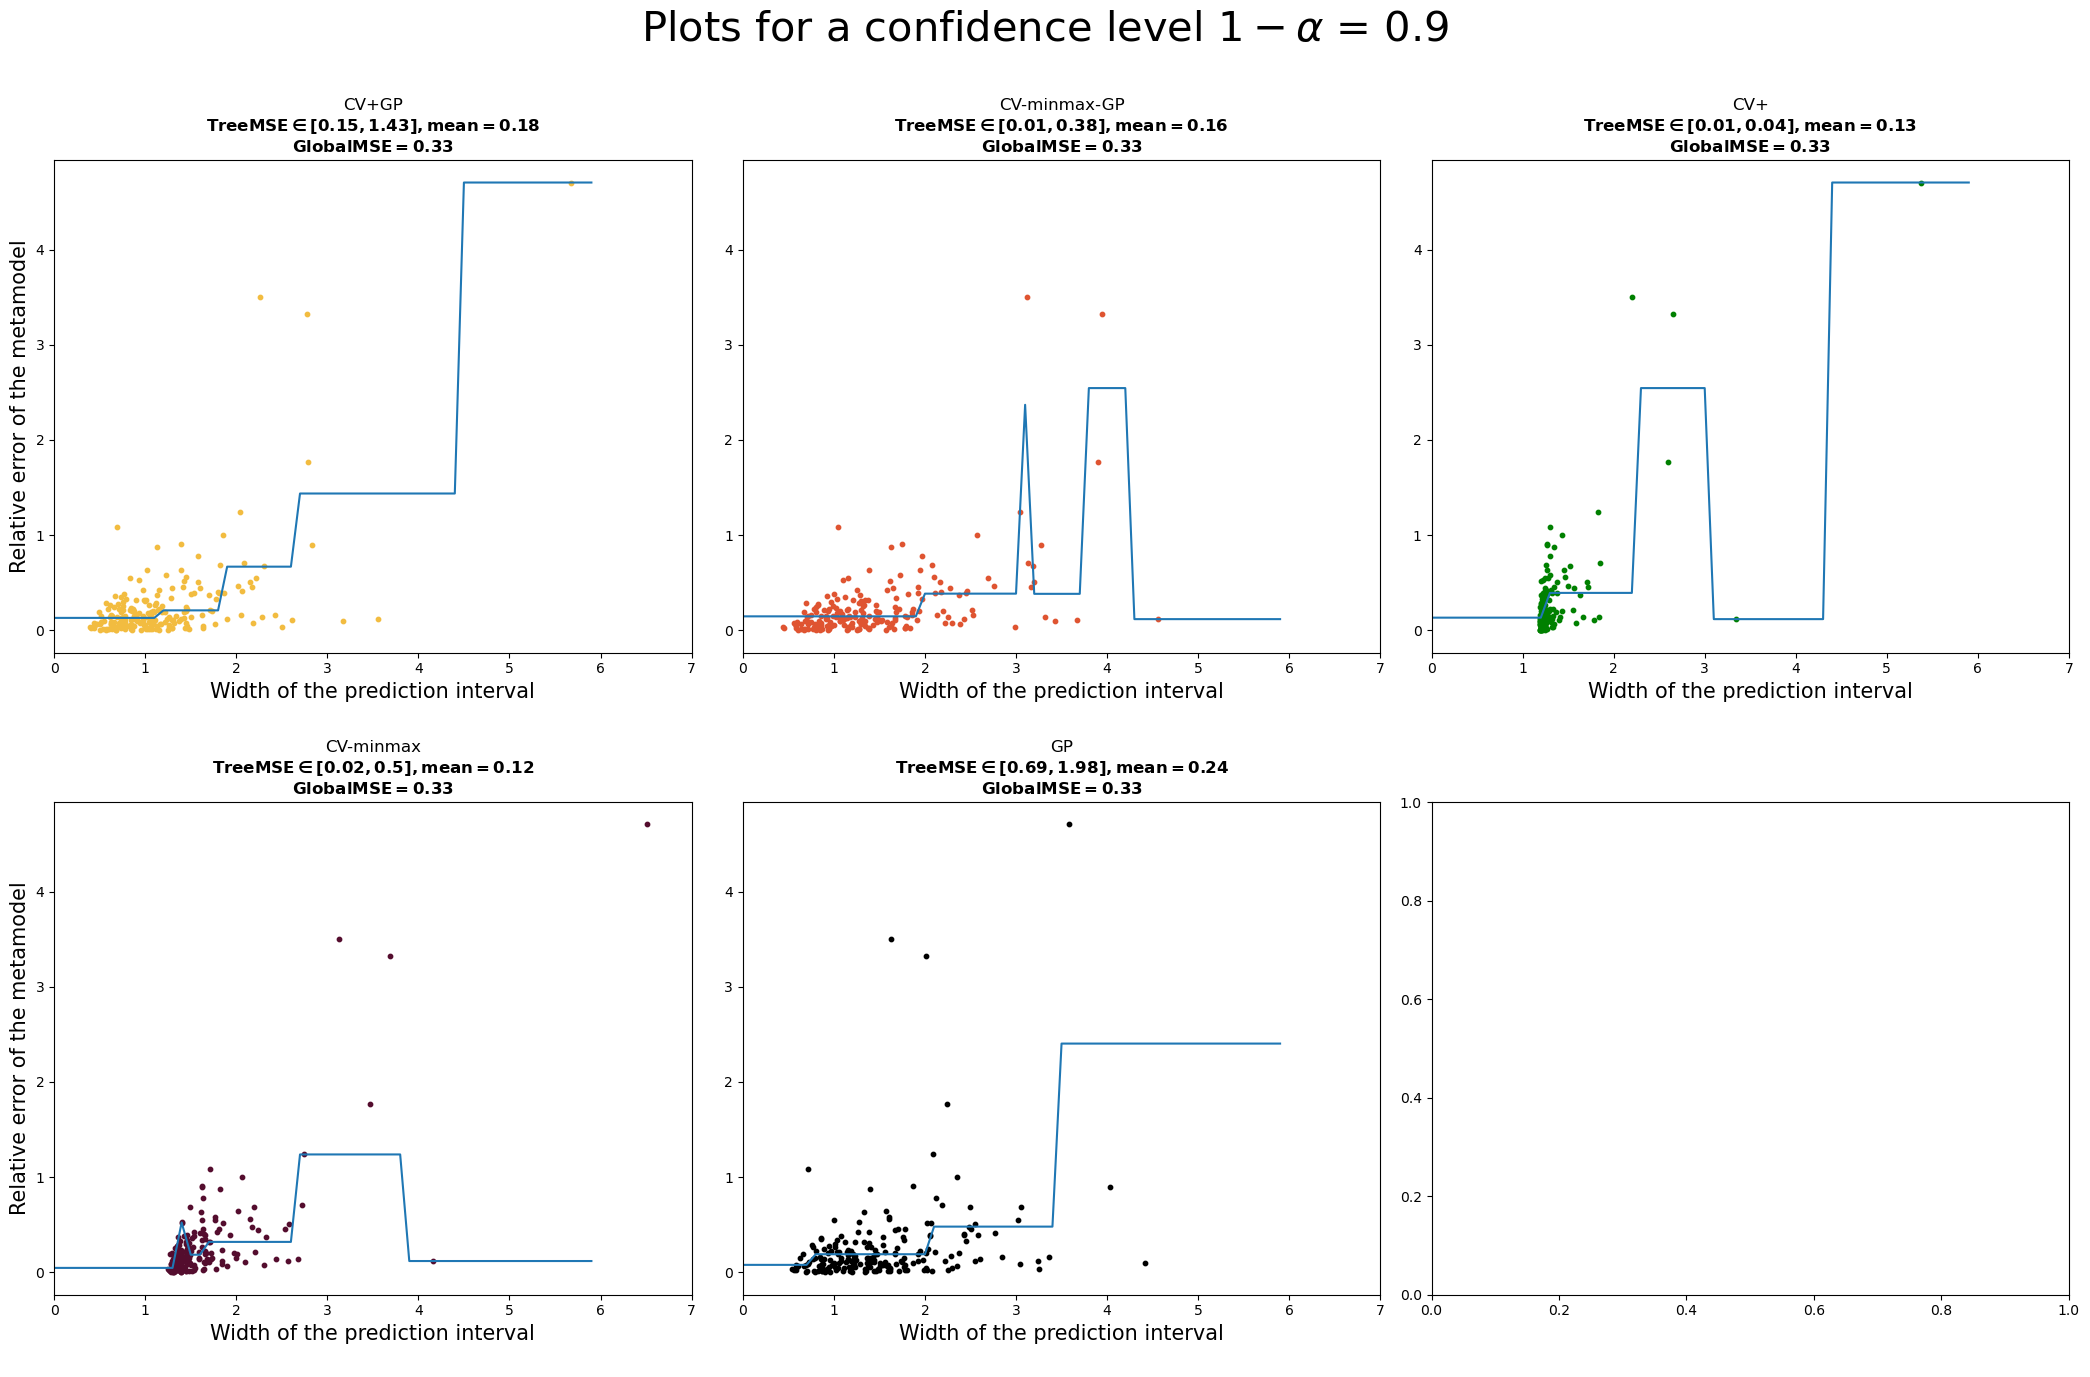

In [35]:
ncols = 3
nrows = len(models) // ncols + (len(models) % ncols != 0)
s = 7
f, ax = plt.subplots(nrows, ncols, figsize=(ncols * s, nrows * s), squeeze=False)
ci_name = "Tree MSE"


for i, (model_name, model) in enumerate(models.items()):
    X_temp = model["width"]
    y_temp = model["errors"]
    X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(X_temp, y_temp, test_size=.3)
    tree = DecisionTreeRegressor(min_samples_split=3, max_depth=3).fit(X_temp_train.reshape(-1, 1), y_temp_train)
    pred = tree.predict(np.arange(0, 6, .1).reshape(-1, 1))
    r, c = i // ncols, i % ncols
    ax[r, c].plot(np.arange(0, 6, .1), pred)
    ci = model["tree_mse"].confidence_interval
    mean_mse = model["tree_mse"].bootstrap_distribution.mean()
    plot_width_error(model, model_name, ci, mean_mse, ci_name, ax, r, c)
f.suptitle(r"Plots for a confidence level $1 - \alpha$ = " + str(round(1 - ALPHA[9], 2)) + "\n", fontsize=30)

plt.tight_layout()

# MMD

In [36]:
for model_name, model in models.items():
    width = np.array(model["average_width"])[:, np.newaxis]
    error = model["errors"][:, np.newaxis]
    model["mmd_linear"] = mmd.mmd_linear(width, error)
    model["mmd_rbf"] = mmd.mmd_rbf(width, error)
    model["mmd_poly"] = mmd.mmd_poly(width, error)

In [37]:
pd.DataFrame(models).loc[["mmd_linear", "mmd_rbf", "mmd_poly"]]

,CV+GP,CV-minmax-GP,CV+,CV-minmax,GP
mmd_linear,0.061982,0.37443,0.086905,0.426736,0.215775
mmd_rbf,0.053002,0.366866,0.051807,0.345037,0.227709
mmd_poly,0.080837,0.601149,0.300779,1.161763,0.237561
